# Spatial heatmap plotting of the specific genes of some special cortical regions

In [1]:
# author: Yuhan Jia (jiayuhan21@mails.ucas.ac.cn) and Yiyang Zhang (zhangyiyang1328@163.com)
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
import itertools
import torch
import math
# from evaluation import eva
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import os
import scipy.sparse as sp
import scipy.linalg
from sklearn.metrics import adjusted_rand_score as ari_score

import numpy as np
seed=666

import random
random.seed(seed)

np.random.seed(seed)

import tqdm
from pandas.api.types import CategoricalDtype

In [2]:
Batch_list = []

section_ids = ['ST_3M_AD_1_1', 'ST_3M_AD_1_2', 'ST_3M_WT_1_1', 'ST_3M_WT_1_2',
               'ST_6M_AD_2_1', 'ST_6M_AD_2_2', 'ST_6M_WT_2_1', 'ST_6M_WT_2_2',
               'ST_15M_AD_2_1', 'ST_15M_AD_2_2', 'ST_15M_WT_2_1', 'ST_15M_WT_2_2'] 

In [3]:
for section_id in section_ids:
    print(section_id)
    
    # The path to Data
    input_dir0 = os.path.join('D:/Users/zyzhang/Alzheimer/st/', section_id)
    adata = sc.read_visium(path=input_dir0, count_file='filtered_feature_bc_matrix.h5',
                           load_images=True)
    
    if_choose_file = pd.read_csv(input_dir0 + '/if_choose.csv', index_col=0, sep=',')
    barcodes_for_choose = if_choose_file[if_choose_file['if_choose']== 1].index 
    adata = adata[barcodes_for_choose, ]
    
    adata.var_names_make_unique(join="++")
    
    # Normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    Batch_list.append(adata)

ST_3M_AD_1_1
ST_3M_AD_1_2
ST_3M_WT_1_1
ST_3M_WT_1_2
ST_6M_AD_2_1
ST_6M_AD_2_2
ST_6M_WT_2_1
ST_6M_WT_2_2
ST_15M_AD_2_1
ST_15M_AD_2_2
ST_15M_WT_2_1
ST_15M_WT_2_2


In [4]:
for m in range(len(Batch_list)):
    # Read the clustering results from STAligner
    STAligner_results = pd.read_csv(f'./results/STAligner/256hidden/{section_ids[m]}.csv',
                                    index_col=0, sep=',', header=0)
    
    Batch_list[m].obs['STAligner'] = STAligner_results.loc[Batch_list[m].obs_names, 
                                                           'STAligner'].map(lambda x: str(x))

In [5]:
map_dict = {
    "1": "L5",
    "2": "AIp",
    "3": "L6",
    "4": "CTXsp-1",
    "5": "L4",
    "6": "TH-2",
    "7": "SI",
    "8": "HY",
    "9": "CA-1",
    "10": "sAMY",
    "11": "L2/3",
    "12": "L1",
    "13": "STRD-1",
    "14": "OPT",
    "15": "PIR-1",
    "16": "TH-1",
    "17": "CA-2",
    "18": "VL",
    "19": "DORsm",
    "20": "CC",
    "21": "STRD-2",
    "22": "PIR-2",
    "23": "DG",
    "24": "CTXsp-2",
    "25": "RT"
}

In [6]:
for m in tqdm.tqdm(range(len(Batch_list))):
    Batch_list[m].obs['STAligner'] = Batch_list[m].obs['STAligner'].map(lambda x:map_dict[x])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1200.03it/s]


In [7]:
Merge_regions_dict = {
    'L2/3': 'Cerebral cortex',
    'CTXsp-1': 'Cerebral nuclei',
    'DG': 'Hippocampal region',
    'CA-2': 'Hippocampal region',
    'sAMY': 'Cerebral nuclei',
    'AIp': 'Cerebral cortex',
    'HY': 'Hypothalamus',
    'PIR-1': 'Cerebral cortex',
    'PIR-2': 'Cerebral cortex',
    'L5': 'Cerebral cortex',
    'CC': 'Fiber tracts',
    'SI': 'Cerebral nuclei',
    'CA-1': 'Hippocampal region',
    'L6': 'Cerebral cortex',
    'L1': 'Cerebral cortex',
    'VL': 'Ventricular systems',
    'DORsm': 'Thalamus',
    'TH-2': 'Thalamus',
    'CTXsp-2': 'Cerebral nuclei',
    'TH-1': 'Thalamus',
    'OPT': 'Fiber tracts',
    'STRD-1': 'Cerebral nuclei',
    'L4': 'Cerebral cortex',
    'STRD-2': 'Cerebral nuclei',
    'RT': 'Thalamus'
}

In [8]:
for m in tqdm.tqdm(range(len(Batch_list))):
    Batch_list[m].obs['Merge_regions'] = Batch_list[m].obs['STAligner'].map(lambda x:Merge_regions_dict[x])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1090.89it/s]


## Merage data

In [9]:
adata_vis = ad.concat(Batch_list, label="batch_name", keys=section_ids)
adata_vis

AnnData object with n_obs × n_vars = 32022 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'STAligner', 'Merge_regions', 'batch_name'
    obsm: 'spatial'

In [10]:
Merge_regions_dict = {
    'L2/3': 'Cerebral cortex',
    'CTXsp-1': 'Cerebral nuclei',
    'DG': 'Hippocampal region',
    'CA-2': 'Hippocampal region',
    'sAMY': 'Cerebral nuclei',
    'AIp': 'Cerebral cortex',
    'HY': 'Hypothalamus',
    'PIR-1': 'Cerebral cortex',
    'PIR-2': 'Cerebral cortex',
    'L5': 'Cerebral cortex',
    'CC': 'Fiber tracts',
    'SI': 'Cerebral nuclei',
    'CA-1': 'Hippocampal region',
    'L6': 'Cerebral cortex',
    'L1': 'Cerebral cortex',
    'VL': 'Ventricular systems',
    'DORsm': 'Thalamus',
    'TH-2': 'Thalamus',
    'CTXsp-2': 'Cerebral nuclei',
    'TH-1': 'Thalamus',
    'OPT': 'Fiber tracts',
    'STRD-1': 'Cerebral nuclei',
    'L4': 'Cerebral cortex',
    'STRD-2': 'Cerebral nuclei',
    'RT': 'Thalamus'
}

adata_vis.obs['Merge_regions'] = adata_vis.obs['STAligner'].map(lambda x:Merge_regions_dict[x])

## find DEG on 7 merge regions

In [11]:
sc.pp.highly_variable_genes(adata_vis, n_top_genes=3000)
sc.tl.rank_genes_groups(adata_vis, 'Merge_regions', method='wilcoxon') 

for region in tqdm.tqdm(adata_vis.obs.Merge_regions.unique().tolist()):
    if not os.path.exists(f'./results/Scanpy_SVG_Merge_regions'):
        os.makedirs(f'./results/Scanpy_SVG_Merge_regions')

    marker = sc.get.rank_genes_groups_df(adata_vis, group=str(region), 
                                         log2fc_min=1, 
                                         pval_cutoff=0.001)
    marker.to_csv(f'./results/Scanpy_SVG_Merge_regions/region_{region}.csv')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


## find DEG on 25 domains

In [12]:
sc.pp.highly_variable_genes(adata_vis, n_top_genes=3000)
sc.tl.rank_genes_groups(adata_vis, 'STAligner', method='wilcoxon') 

for dom in tqdm.tqdm(adata_vis.obs.STAligner.unique().tolist()):
    if not os.path.exists(f'./results/Scanpy_SVG'):
        os.makedirs(f'./results/Scanpy_SVG')

    marker = sc.get.rank_genes_groups_df(adata_vis, group=str(dom), 
                                         log2fc_min=1, 
                                         pval_cutoff=0.001)
    dom = dom.replace("/", "_")
    marker.to_csv(f'./results/Scanpy_SVG/domain_{dom}.csv')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.84it/s]


In [13]:
markers_all = pd.DataFrame()

for dom in tqdm.tqdm(adata_vis.obs.STAligner.unique().tolist()):
    dom = dom.replace("/", "_")

    marker = pd.read_csv(f'./results/Scanpy_SVG/domain_{dom}.csv', index_col=0).loc[:, ['names', 'logfoldchanges']]
    
    marker.colunms = ['SVG']
    marker['domain'] = f'domain_{dom}'
    
    if markers_all.shape == (0, 0):
        markers_all = marker
    else:
        markers_all = pd.concat([markers_all, marker], axis=0)
markers_all

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 118.67it/s]


,names,logfoldchanges,domain
0,Lamp5,3.273246,domain_L2_3
1,Nrgn,2.613881,domain_L2_3
2,Camk2n1,1.830131,domain_L2_3
3,Atp1a1,1.863519,domain_L2_3
4,Mef2c,2.071525,domain_L2_3
...,...,...,...
727,Tmem114,1.338066,domain_DG
728,Ttc26,1.088607,domain_DG
729,Dbh,4.403771,domain_DG
730,Plod2,1.548308,domain_DG


In [14]:
custom_order = [
     'L1', 'L2/3', 'L4', 'L5', 'L6', 'PIR-1', 'PIR-2', 'AIp',
     'CTXsp-1', 'CTXsp-2', 'STRD-1', 'STRD-2', 'SI', 'sAMY',
     'DG', 'CA-1', 'CA-2',
     'TH-1', 'TH-2', 'RT', 'DORsm',
     'CC', 'OPT',
     'HY',
     'VL',
]

In [15]:
n_top = 10
markers_all = markers_all.groupby('domain').apply(lambda x: x.nlargest(n_top, 
                                                                       'logfoldchanges')).reset_index(drop=True)
markers_all = markers_all.drop_duplicates('names')

markers_all.domain = markers_all.domain.astype('category')
custom_order_domain = ['domain_' + _.replace("/", "_") for _ in custom_order]
cat_type = CategoricalDtype(categories=custom_order_domain, ordered=True)
markers_all.domain = markers_all.domain.astype(cat_type)
markers_all = markers_all.sort_values('domain')
markers_all

,names,logfoldchanges,domain
90,Prg4,3.727119,domain_L1
99,Agmat,2.325585,domain_L1
98,Clec18a,2.363059,domain_L1
97,Fst,2.395179,domain_L1
96,Ogn,2.400509,domain_L1
...,...,...,...
235,Frmpd1os,7.502846,domain_VL
234,Pon1,7.528309,domain_VL
233,Sult1c1,7.571255,domain_VL
231,4933429O19Rik,7.742256,domain_VL


In [16]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=custom_order, ordered=True)
adata_vis.obs['STAligner'] = adata_vis.obs['STAligner'].astype(cat_type)

In [17]:
adata_plot = pd.concat([adata_vis.to_df().loc[:, markers_all['names'].tolist()], 
                        adata_vis.obs.STAligner], axis=1)
adata_plot

,Prg4,Agmat,Clec18a,Fst,Ogn,Slc22a6,Vip,Gm765,Fmod,Myoc,...,2900040C04Rik,Gm32468,Sult1c2,Tmprss11a,Frmpd1os,Pon1,Sult1c1,4933429O19Rik,Ttr,STAligner
AAACAAGTATCTCCCA-1,0.0,0.0,0.000000,0.307673,0.0,0.0,2.711378,0.000000,0.0,0.307673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.188928,L2/3
AAACAGAGCGACTCCT-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.840619,TH-1
AAACCGGGTAGGTACC-1,0.0,0.0,0.200147,0.000000,0.0,0.0,0.366838,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.168083,L5
AAACCGTTCGTCCAGG-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.580971,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.597136,L4
AAACCTCATGAAGTTG-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.257689,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.442981,L4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.124535,DORsm
TTGTTCTAGATACGCT-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.950323,L5
TTGTTGTGTGTCAAGA-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.594114,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.445907,RT
TTGTTTCACATCCAGG-1,0.0,0.0,0.000000,0.000000,0.0,0.0,1.275915,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.818719,L2/3


In [18]:
adata_plot = adata_plot.groupby('STAligner').mean()
adata_plot = adata_plot.loc[[_ for _ in custom_order], ]
adata_plot

,Prg4,Agmat,Clec18a,Fst,Ogn,Slc22a6,Vip,Gm765,Fmod,Myoc,...,Olfr570,2900040C04Rik,Gm32468,Sult1c2,Tmprss11a,Frmpd1os,Pon1,Sult1c1,4933429O19Rik,Ttr
STAligner,,,,,,,,,,,,,,,,,,,,,
L1,0.116012,0.059726,0.092795,0.063895,0.122190,0.134598,0.629578,0.097305,0.169173,0.305985,...,0.000354,0.015809,0.000290,0.000000,0.000593,0.001277,0.001369,0.000000,0.000000,1.404646
L2/3,0.010488,0.071742,0.099195,0.053228,0.013248,0.015294,0.652104,0.157809,0.024861,0.047334,...,0.000000,0.007578,0.001059,0.000750,0.000572,0.000457,0.000000,0.000252,0.000000,1.253303
L4,0.006310,0.022634,0.028860,0.015011,0.010784,0.010695,0.396082,0.063274,0.014298,0.020665,...,0.000000,0.007770,0.000950,0.000488,0.000304,0.000409,0.000725,0.000000,0.000652,1.222979
L5,0.003531,0.008545,0.014941,0.010304,0.007179,0.007566,0.252459,0.027441,0.011361,0.021069,...,0.000268,0.009870,0.001180,0.000723,0.000459,0.000463,0.000136,0.000383,0.000236,1.255963
L6,0.001624,0.008485,0.025340,0.030859,0.007850,0.004987,0.186770,0.014673,0.008831,0.010918,...,0.000220,0.014716,0.001474,0.000556,0.000510,0.001332,0.000776,0.000000,0.000903,1.455371
PIR-1,0.012650,0.023155,0.022029,0.009530,0.015305,0.018017,0.330490,0.001871,0.020426,0.049961,...,0.000000,0.010703,0.000247,0.001916,0.001849,0.001078,0.000352,0.000990,0.000706,1.158188
PIR-2,0.100594,0.015286,0.020904,0.009089,0.166669,0.190743,0.190089,0.002169,0.215625,0.461757,...,0.000000,0.025127,0.002867,0.000900,0.000740,0.001027,0.000000,0.000000,0.000000,1.387928
AIp,0.004445,0.014329,0.054266,0.018646,0.010325,0.007722,0.328095,0.006702,0.010407,0.025157,...,0.000000,0.015953,0.001947,0.000757,0.001108,0.000844,0.000000,0.000000,0.000000,1.231736
CTXsp-1,0.012026,0.006348,0.031430,0.008595,0.025964,0.022706,0.272865,0.002674,0.031499,0.068837,...,0.000236,0.046040,0.005530,0.004219,0.002041,0.003848,0.001229,0.004100,0.001164,1.808825


## Read Specific Genes

In [19]:
Specific_Genes = pd.read_excel('./Specific_Genes.xlsx')
Specific_Genes = Specific_Genes.values.flatten()
Specific_Genes = list(set(Specific_Genes))
Specific_Genes = [x for x in Specific_Genes if str(x) != 'nan' and str(x) != '✓']

capitalized_list = [word.capitalize() for word in Specific_Genes]
capitalized_list = [_ for _ in capitalized_list if _ in adata_vis.var_names]

## Read Region SVG

In [20]:
markers_region = pd.DataFrame()

for region in tqdm.tqdm(adata_vis.obs.Merge_regions.unique().tolist()):
    marker = pd.read_csv(f'./results/Scanpy_SVG_Merge_regions/region_{region}.csv', index_col=0).loc[:, ['names', 'logfoldchanges']]
    
    marker.colunms = ['SVG']
    marker['region'] = f'region_{region}'
    
    if markers_region.shape == (0, 0):
        markers_region = marker
    else:
        markers_region = pd.concat([markers_region, marker], axis=0)
markers_region

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 116.66it/s]


,names,logfoldchanges,region
0,Mef2c,2.395119,region_Cerebral cortex
1,Camk2n1,1.585138,region_Cerebral cortex
2,Nrgn,2.521988,region_Cerebral cortex
3,1110008P14Rik,1.674494,region_Cerebral cortex
4,Cabp1,2.250213,region_Cerebral cortex
...,...,...,...
357,Scgn,1.827872,region_Hippocampal region
358,Mc4r,1.090330,region_Hippocampal region
359,Tmprss6,1.815723,region_Hippocampal region
360,Mndal,1.975024,region_Hippocampal region


In [21]:
n_top = 1
markers_region = markers_region.groupby('region').apply(lambda x: x.nlargest(n_top, 
                                                                       'logfoldchanges')).reset_index(drop=True)
markers_region = markers_region.drop_duplicates('names')
markers_region = markers_region.sort_values('region')
markers_region

,names,logfoldchanges,region
0,Gm13601,3.728377,region_Cerebral cortex
1,Gm39043,4.308068,region_Cerebral nuclei
2,Plp1,3.319073,region_Fiber tracts
3,Pla2g2f,5.627985,region_Hippocampal region
4,Mup6,5.855616,region_Hypothalamus
5,Shox2,5.501032,region_Thalamus
6,Ttr,8.043669,region_Ventricular systems


## Heatmap plot

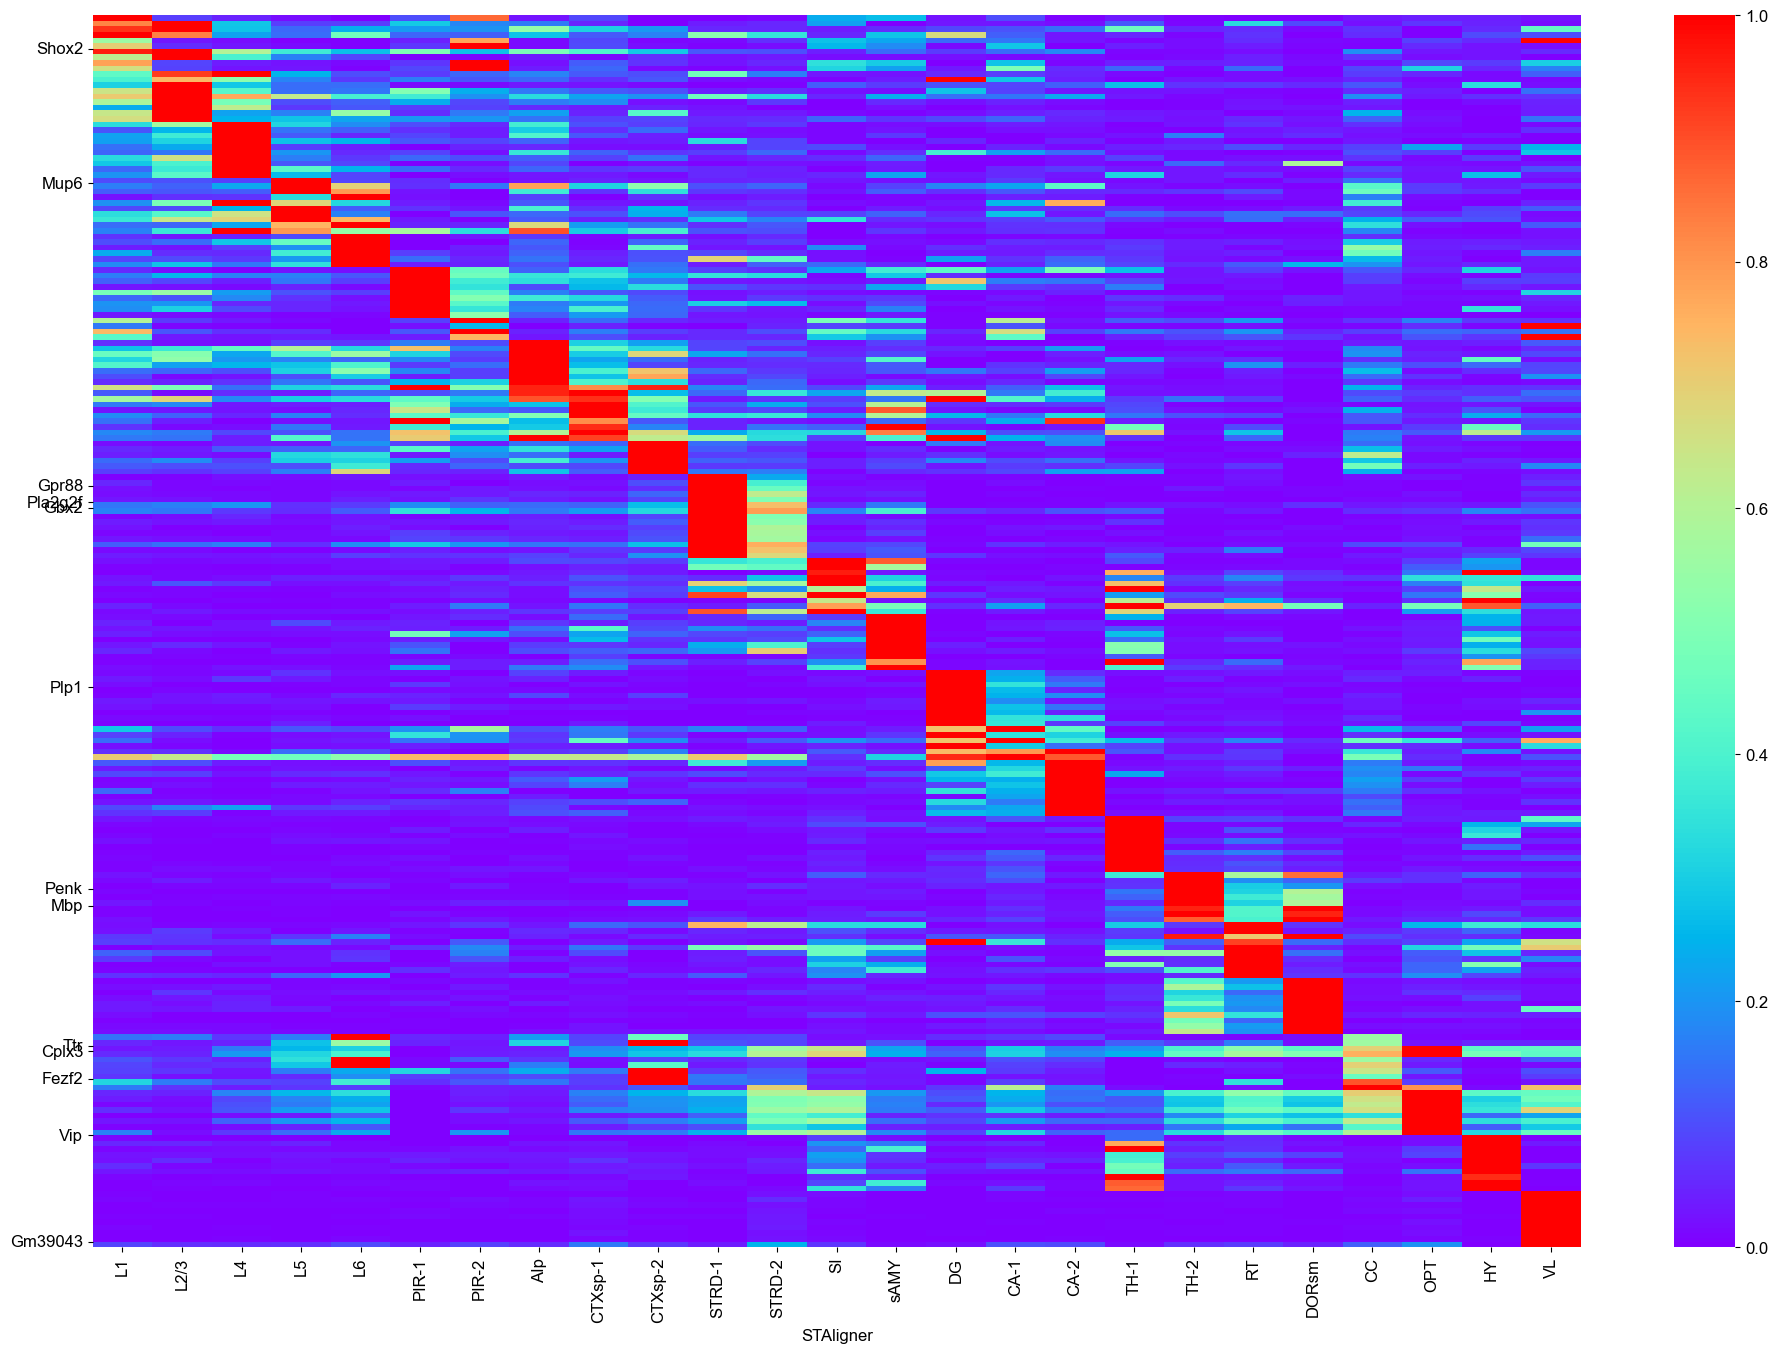

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors

plt.figure(figsize=(24, 16))
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 12

scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(adata_plot), columns=adata_plot.columns, index=adata_plot.index).T

heatmap = sns.heatmap(df_scaled, annot=False, fmt='.2f', xticklabels=True, yticklabels=True, 
                      robust=True, cmap='rainbow')

rows_to_display = list(set(capitalized_list + markers_region['names'].tolist()).intersection(set(adata_plot.columns)))

all_rows = df_scaled.index

display_positions = [i for i, row_name in enumerate(all_rows) if row_name in rows_to_display]

heatmap.set_yticks(display_positions)
heatmap.set_yticklabels(rows_to_display)
        
save_path = './results/heatmap plotting of the specific genes of some special cortical regions/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

plt.savefig(f'{save_path}/sample_plot.pdf', format='pdf')
plt.savefig(f'{save_path}/sample_plot.png', format='png')

plt.show()